In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import sys
import sklearn.model_selection
from sklearn.preprocessing import LabelEncoder
#set directory
os.getcwd()
os.chdir("/ysm-gpfs/pi/zhao/zy92/projects/ddipred/ddi_pred/data")

#list of desired DDI Types
desired_DDI = [0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 18, 19, 20, 21, 22, 26, 28, 30, 31, 32, 38, 40, 41, 43, 44, 45,
               49, 50, 51, 52, 54, 55, 62, 67, 68, 72, 74, 76, 78, 79, 80, 81]




In [2]:
ddidata = pd.read_excel("DrugBank_known_ddi.xlsx")
interactiondict = pd.read_csv("Interaction_information.csv")
safe_drugs = pd.read_csv("safe_drug_combos.csv")
drug_similarity_feature = pd.read_csv("drug_similarity.csv")
drug_similarity = drug_similarity_feature.iloc[:, 1:len(drug_similarity_feature)+1]
#filter ddidata for desired DDI types
up_ddidata = ddidata[ddidata.Label.isin(desired_DDI)]
new_ddidata = up_ddidata.copy()
#convert types to int
new_ddidata.drug1 = up_ddidata.drug1.str[2:].astype(int)
new_ddidata.drug2 = up_ddidata.drug2.str[2:].astype(int)
new_ddidata.Label = up_ddidata.Label

In [3]:
#Incorporate safe_drugs into new_ddidata with DDIType 0
safe_drugs["Label"] = 0

frames = [safe_drugs, new_ddidata]
ddi_df = pd.concat(frames)

#create a DB to index dictionary from similarity dataset
DB_to_index = {}
i = 0
for col in drug_similarity.columns:
    DB_to_index[int(col[2:7])] = i
    i = i + 1

#filter output to only include DBs with similarity features
ddi_df_output = ddi_df[ddi_df.drug1.isin(DB_to_index)]
ddi_output = ddi_df_output[ddi_df_output.drug2.isin(DB_to_index)]
ddi_output.tail()

,drug1,drug2,Label
190256,655,461,81
190257,1041,367,81
190258,1395,302,81
190259,302,1357,81
190260,480,655,81


In [4]:
count = {}
#initialize dict
for i in range(0, 82):
    count[i] = 0
    
#count number of examples for each DDItype
for i in range(0, 82):
    if i in desired_DDI:
        count[i] = len(ddi_output[ddi_output.Label == (i)])
    


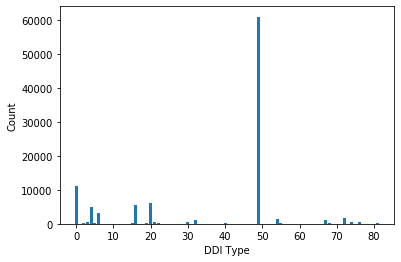

In [5]:
#plot count
plt.bar(range(len(count)), list(count.values()))
plt.xlabel("DDI Type")
plt.ylabel("Count")
plt.show()

### checking the overlap

In [6]:
print(ddi_df_output.head())
ddi_df_output.shape

   drug1  drug2  Label
0    956    316      0
1    977    717      0
2    977    957      0
3   1060    766      0
4   1395    977      0


(102882, 3)

In [7]:
set(ddi_output.iloc[0,0:2])

{316, 956}

In [8]:
ddi_series = ddi_output.apply(lambda x: set(x[0:2]), axis=1)
ddi_set_df = pd.DataFrame({
    'Drug Set': ddi_series, 
    'Label': ddi_output.Label 
})

In [9]:
ddi_set_df.head()


,Drug Set,Label
0,"{956, 316}",0
1,"{977, 717}",0
2,"{977, 957}",0
3,"{1060, 766}",0
4,"{977, 1395}",0


In [10]:
ddi_set_df.groupby('Label').count().transpose()

Label,0,1,2,3,4,5,6,7,15,16,...,62,67,68,72,74,76,78,79,80,81
Drug Set,11077,11,323,519,5011,309,3160,21,202,5435,...,11,1092,278,1825,422,558,28,27,64,108


In [11]:
ddi_set_df.head()

,Drug Set,Label
0,"{956, 316}",0
1,"{977, 717}",0
2,"{977, 957}",0
3,"{1060, 766}",0
4,"{977, 1395}",0


In [12]:
exchange_func = lambda x: x[[2,0,1]] if x[0] > x[1] else x[[2,1,0]]
ddi_df_sorted = ddi_output.apply(exchange_func, axis=1)


In [13]:
ddi_df_sorted.head()

,Label,drug1,drug2
0,0,956,316
1,0,977,717
2,0,977,957
3,0,1060,766
4,0,1395,977


In [14]:
bool_series = ddi_df_sorted[['drug1', 'drug2']].duplicated(keep = False)
ddi_df_sorted[bool_series]

,Label,drug1,drug2
1379,4,564,1171
2474,4,564,1037
15152,16,921,752
85272,49,564,1037
88253,49,564,1171
115634,49,921,752


In [15]:
bool_series_to_delete = ddi_output[['drug1', 'drug2']].duplicated()
ddi_clean = ddi_output[~bool_series_to_delete]

In [16]:
ddi_clean.head()

,drug1,drug2,Label
0,956,316,0
1,977,717,0
2,977,957,0
3,1060,766,0
4,1395,977,0


In [17]:
ddi_clean.shape

(101992, 3)

In [18]:
len(DB_to_index)

2159

In [19]:
#add similarity feature for each drug-drug pair
n_similarity = 2159
sim_array = np.empty([ddi_clean.shape[0], 2*n_similarity], dtype='float16')
i = 0
for index, (_, row) in enumerate(ddi_clean.iterrows()):
    if index % 10000 == 0:
        print("INFO: iter " + str(index + 1))
    drug1_index = DB_to_index[row["drug1"]]
    drug2_index = DB_to_index[row["drug2"]]
    feature_vec = np.hstack([drug_similarity.iloc[:,drug1_index],drug_similarity.iloc[:,drug2_index]])
    sim_array[index, ] = feature_vec

INFO: iter 1
INFO: iter 10001
INFO: iter 20001
INFO: iter 30001
INFO: iter 40001
INFO: iter 50001
INFO: iter 60001
INFO: iter 70001
INFO: iter 80001
INFO: iter 90001
INFO: iter 100001


In [20]:
sim_array[0:6,]

array([[0.1703 , 0.257  , 0.1139 , ..., 0.2084 , 0.1605 , 0.05606],
       [0.193  , 0.2646 , 0.1102 , ..., 0.0758 , 0.2491 , 0.04837],
       [0.193  , 0.2646 , 0.1102 , ..., 0.0763 , 0.2952 , 0.07074],
       [0.1964 , 0.3    , 0.161  , ..., 0.1316 , 0.1349 , 0.0367 ],
       [0.1968 , 0.2426 , 0.1144 , ..., 0.11536, 0.261  , 0.06415],
       [0.1931 , 0.2418 , 0.1114 , ..., 0.11536, 0.261  , 0.06415]],
      dtype=float16)

In [21]:
sim_array.shape

(101992, 4318)

In [22]:
import tensorflow as tf
#Create input and output vectors for training

X_data = sim_array
y_data = np.array(ddi_clean.Label)

# transform the y
encoder = LabelEncoder()
encoder.fit(y_data)
encoded_Y = encoder.transform(y_data)
y_data = tf.keras.utils.to_categorical(encoded_Y)


X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_data, y_data, test_size = 0.3
                                                                           , random_state =1)
X_test, X_val, y_test, y_val = sklearn.model_selection.train_test_split(X_test, y_test, test_size = 0.5
                                                                       , random_state = 1)

train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_set = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

BATCH_SIZE = 256
SHUFFLE_BUFFER_SIZE = 1024

train_set = train_set.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_set = test_set.batch(BATCH_SIZE)

In [23]:
X_data[1,]

array([0.193  , 0.2646 , 0.1102 , ..., 0.0758 , 0.2491 , 0.04837],
      dtype=float16)

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation = 'relu', input_dim = 4318),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(43, activation='softmax')

])


model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5), 
              metrics=['accuracy'])


In [25]:
covertion_dict = {}


In [ ]:
history_step_5000 = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5000, batch_size=BATCH_SIZE)

Train on 71394 samples, validate on 15299 samples
Epoch 1/5000
71394/71394 [==============================] - 6s 89us/sample - loss: 1.9197 - accuracy: 0.5652 - val_loss: 1.6274 - val_accuracy: 0.5974
Epoch 2/5000
71394/71394 [==============================] - 5s 76us/sample - loss: 1.5895 - accuracy: 0.5988 - val_loss: 1.5585 - val_accuracy: 0.5974
Epoch 3/5000
71394/71394 [==============================] - 5s 75us/sample - loss: 1.5369 - accuracy: 0.5987 - val_loss: 1.5148 - val_accuracy: 0.5972
Epoch 4/5000
71394/71394 [==============================] - 6s 80us/sample - loss: 1.4991 - accuracy: 0.5987 - val_loss: 1.4788 - val_accuracy: 0.5972
Epoch 5/5000
71394/71394 [==============================] - 6s 78us/sample - loss: 1.4654 - accuracy: 0.5989 - val_loss: 1.4468 - val_accuracy: 0.5974
Epoch 6/5000
71394/71394 [==============================] - 6s 78us/sample - loss: 1.4356 - accuracy: 0.6009 - val_loss: 1.4183 - val_accuracy: 0.6019
Epoch 7/5000
71394/71394 [==================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


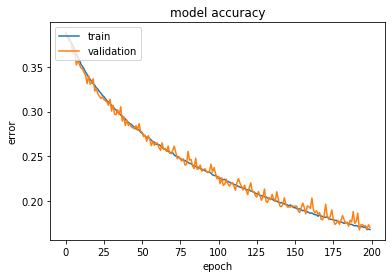

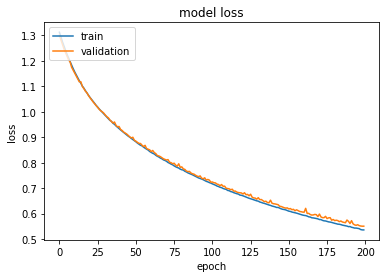

In [160]:
# list all data in history
history = history_step_200
print(history.history.keys())
# summarize history for accuracy
#convert_func = lambda x: 1-x
plt.plot([1 - x for x in history.history['accuracy']])
plt.plot([1 - x for x in history.history['val_accuracy']])
plt.title('model accuracy')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [161]:
model.evaluate(X_val,  y_val, verbose=2)

15299/1 - 1s - loss: 0.5514 - accuracy: 0.8292


[0.5507859913607315, 0.8292045]

In [162]:
model.evaluate(X_test,  y_test, verbose=2)

15299/1 - 1s - loss: 0.4080 - accuracy: 0.8291


[0.5540216964100286, 0.8290738]

In [ ]:
history_step_200_700 = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=BATCH_SIZE)

Train on 71394 samples, validate on 15299 samples
Epoch 1/500
71394/71394 [==============================] - 5s 72us/sample - loss: 0.5354 - accuracy: 0.8313 - val_loss: 0.5467 - val_accuracy: 0.8316
Epoch 2/500
71394/71394 [==============================] - 5s 71us/sample - loss: 0.5330 - accuracy: 0.8319 - val_loss: 0.5464 - val_accuracy: 0.8287
Epoch 3/500
71394/71394 [==============================] - 5s 70us/sample - loss: 0.5321 - accuracy: 0.8325 - val_loss: 0.5564 - val_accuracy: 0.8197
Epoch 4/500
71394/71394 [==============================] - 5s 70us/sample - loss: 0.5315 - accuracy: 0.8324 - val_loss: 0.5457 - val_accuracy: 0.8300
Epoch 5/500
71394/71394 [==============================] - 5s 71us/sample - loss: 0.5293 - accuracy: 0.8324 - val_loss: 0.5428 - val_accuracy: 0.8329
Epoch 6/500
71394/71394 [==============================] - 6s 78us/sample - loss: 0.5300 - accuracy: 0.8341 - val_loss: 0.5451 - val_accuracy: 0.8353
Epoch 7/500
71394/71394 [=========================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


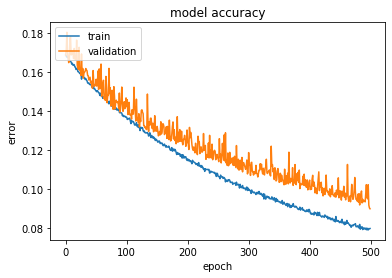

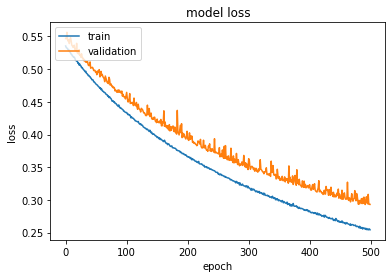

In [164]:
# list all data in history
history = history_step_200_700
print(history.history.keys())
# summarize history for accuracy
#convert_func = lambda x: 1-x
plt.plot([1 - x for x in history.history['accuracy']])
plt.plot([1 - x for x in history.history['val_accuracy']])
plt.title('model accuracy')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [165]:
model.evaluate(X_test,  y_test, verbose=2)

15299/1 - 1s - loss: 0.1865 - accuracy: 0.9127


[0.2918436003072027, 0.912674]

In [166]:
history_step_700_1200 = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=BATCH_SIZE)

Train on 71394 samples, validate on 15299 samples
Epoch 1/500
71394/71394 [==============================] - 5s 70us/sample - loss: 0.2533 - accuracy: 0.9214 - val_loss: 0.2961 - val_accuracy: 0.9034
Epoch 2/500
71394/71394 [==============================] - 5s 70us/sample - loss: 0.2529 - accuracy: 0.9214 - val_loss: 0.2913 - val_accuracy: 0.9054
Epoch 3/500
71394/71394 [==============================] - 5s 70us/sample - loss: 0.2537 - accuracy: 0.9208 - val_loss: 0.2986 - val_accuracy: 0.9055
Epoch 4/500
71394/71394 [==============================] - 5s 71us/sample - loss: 0.2521 - accuracy: 0.9216 - val_loss: 0.2907 - val_accuracy: 0.9094
Epoch 5/500
71394/71394 [==============================] - 5s 71us/sample - loss: 0.2534 - accuracy: 0.9202 - val_loss: 0.2984 - val_accuracy: 0.9082
Epoch 6/500
71394/71394 [==============================] - 5s 71us/sample - loss: 0.2522 - accuracy: 0.9222 - val_loss: 0.2976 - val_accuracy: 0.9015
Epoch 7/500
71394/71394 [=========================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


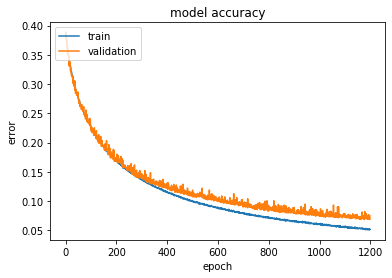

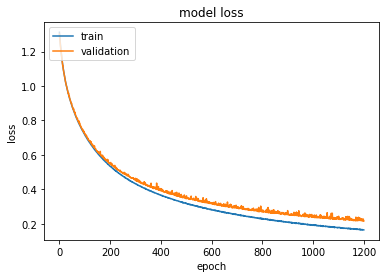

In [167]:
# list all data in history
history_a = history_step_200
history_b = history_step_200_700
history_c = history_step_700_1200
print(history.history.keys())
# summarize history for accuracy
#convert_func = lambda x: 1-x
acc_train = history_a.history['accuracy'] + history_b.history['accuracy'] + history_c.history['accuracy']
acc_val = history_a.history['val_accuracy'] + history_b.history['val_accuracy'] + history_c.history['val_accuracy']
plt.plot([1 - x for x in acc_train])
plt.plot([1 - x for x in acc_val])
plt.title('model accuracy')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
loss_train = history_a.history['loss'] + history_b.history['loss'] + history_c.history['loss']
loss_val = history_a.history['val_loss'] + history_b.history['val_loss'] + history_c.history['val_loss']

plt.plot(loss_train)
plt.plot(loss_val)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [168]:
history_step_1200_1500 = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, batch_size=BATCH_SIZE)

Train on 71394 samples, validate on 15299 samples
Epoch 1/300
71394/71394 [==============================] - 8s 106us/sample - loss: 0.1657 - accuracy: 0.9486 - val_loss: 0.2376 - val_accuracy: 0.9239
Epoch 2/300
71394/71394 [==============================] - 8s 107us/sample - loss: 0.1650 - accuracy: 0.9486 - val_loss: 0.2190 - val_accuracy: 0.9301
Epoch 3/300
71394/71394 [==============================] - 8s 106us/sample - loss: 0.1661 - accuracy: 0.9484 - val_loss: 0.2179 - val_accuracy: 0.9303
Epoch 4/300
71394/71394 [==============================] - 8s 106us/sample - loss: 0.1643 - accuracy: 0.9487 - val_loss: 0.2164 - val_accuracy: 0.9291
Epoch 5/300
71394/71394 [==============================] - 8s 106us/sample - loss: 0.1637 - accuracy: 0.9502 - val_loss: 0.2167 - val_accuracy: 0.9316
Epoch 6/300
71394/71394 [==============================] - 8s 106us/sample - loss: 0.1648 - accuracy: 0.9487 - val_loss: 0.2228 - val_accuracy: 0.9314
Epoch 7/300
71394/71394 [===================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


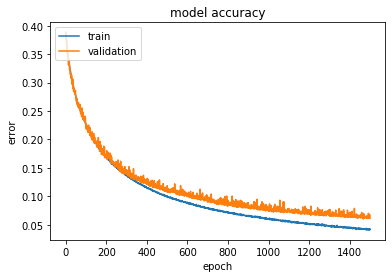

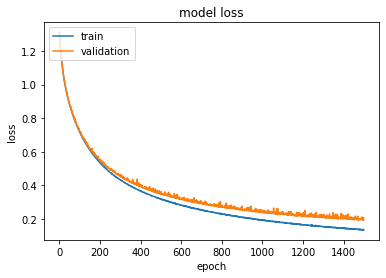

In [170]:
# list all data in history

history_d = history_step_1200_1500
print(history.history.keys())
# summarize history for accuracy
#convert_func = lambda x: 1-x
acc_train = acc_train + history_d.history['accuracy']
acc_val = acc_val + history_d.history['val_accuracy']
plt.plot([1 - x for x in acc_train])
plt.plot([1 - x for x in acc_val])
plt.title('model accuracy')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
loss_train = loss_train + history_d.history['loss']
loss_val = loss_val + history_d.history['val_loss']

plt.plot(loss_train)
plt.plot(loss_val)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [171]:
history_step_1500_2000 = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=BATCH_SIZE)

Train on 71394 samples, validate on 15299 samples
Epoch 1/500
71394/71394 [==============================] - 7s 103us/sample - loss: 0.1355 - accuracy: 0.9584 - val_loss: 0.1937 - val_accuracy: 0.9381
Epoch 2/500
71394/71394 [==============================] - 7s 101us/sample - loss: 0.1350 - accuracy: 0.9587 - val_loss: 0.1939 - val_accuracy: 0.9395
Epoch 3/500
71394/71394 [==============================] - 7s 100us/sample - loss: 0.1349 - accuracy: 0.9585 - val_loss: 0.1958 - val_accuracy: 0.9380
Epoch 4/500
71394/71394 [==============================] - 7s 102us/sample - loss: 0.1348 - accuracy: 0.9585 - val_loss: 0.2064 - val_accuracy: 0.9346
Epoch 5/500
71394/71394 [==============================] - 7s 99us/sample - loss: 0.1351 - accuracy: 0.9584 - val_loss: 0.1938 - val_accuracy: 0.9388
Epoch 6/500
71394/71394 [==============================] - 8s 108us/sample - loss: 0.1354 - accuracy: 0.9582 - val_loss: 0.1943 - val_accuracy: 0.9379
Epoch 7/500
71394/71394 [====================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


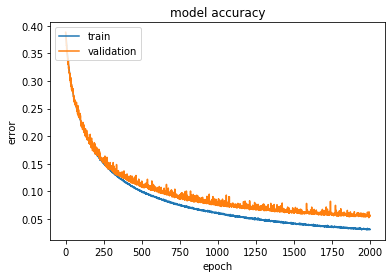

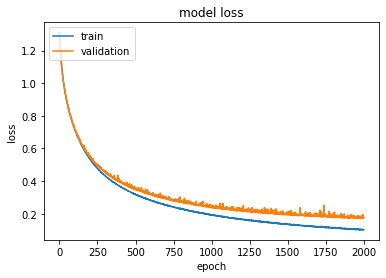

In [172]:
# list all data in history

history_e = history_step_1500_2000
print(history.history.keys())
# summarize history for accuracy
#convert_func = lambda x: 1-x
acc_train = acc_train + history_e.history['accuracy']
acc_val = acc_val + history_e.history['val_accuracy']
plt.plot([1 - x for x in acc_train])
plt.plot([1 - x for x in acc_val])
plt.title('model accuracy')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
loss_train = loss_train + history_e.history['loss']
loss_val = loss_val + history_e.history['val_loss']

plt.plot(loss_train)
plt.plot(loss_val)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [187]:
model.evaluate(X_test,  y_test, verbose=2)

15299/1 - 1s - loss: 0.0967 - accuracy: 0.9457


[0.18072941444388813, 0.9456827]

In [175]:
count = {}
#initialize dict
for i in desired_DDI:
    count[i] = 0
    
#count number of examples for each DDItype
for i in range(0, 82):
    if i in desired_DDI:
        count[i] = len(ddi_clean[ddi_clean.Label == (i)])
    



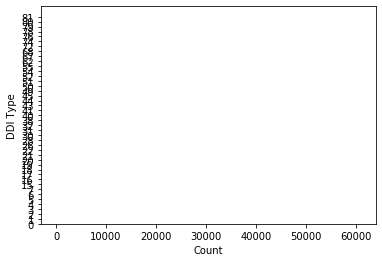

In [180]:
#plot count
desired_DDI_str = [str(x) for x in desired_DDI]
plt.bar(list(count.values()), desired_DDI_str)
plt.ylabel("DDI Type")
plt.xlabel("Count")
plt.show()

In [181]:
plt.figure(figsize=(10,50))

<Figure size 720x3600 with 0 Axes>

<Figure size 720x3600 with 0 Axes>

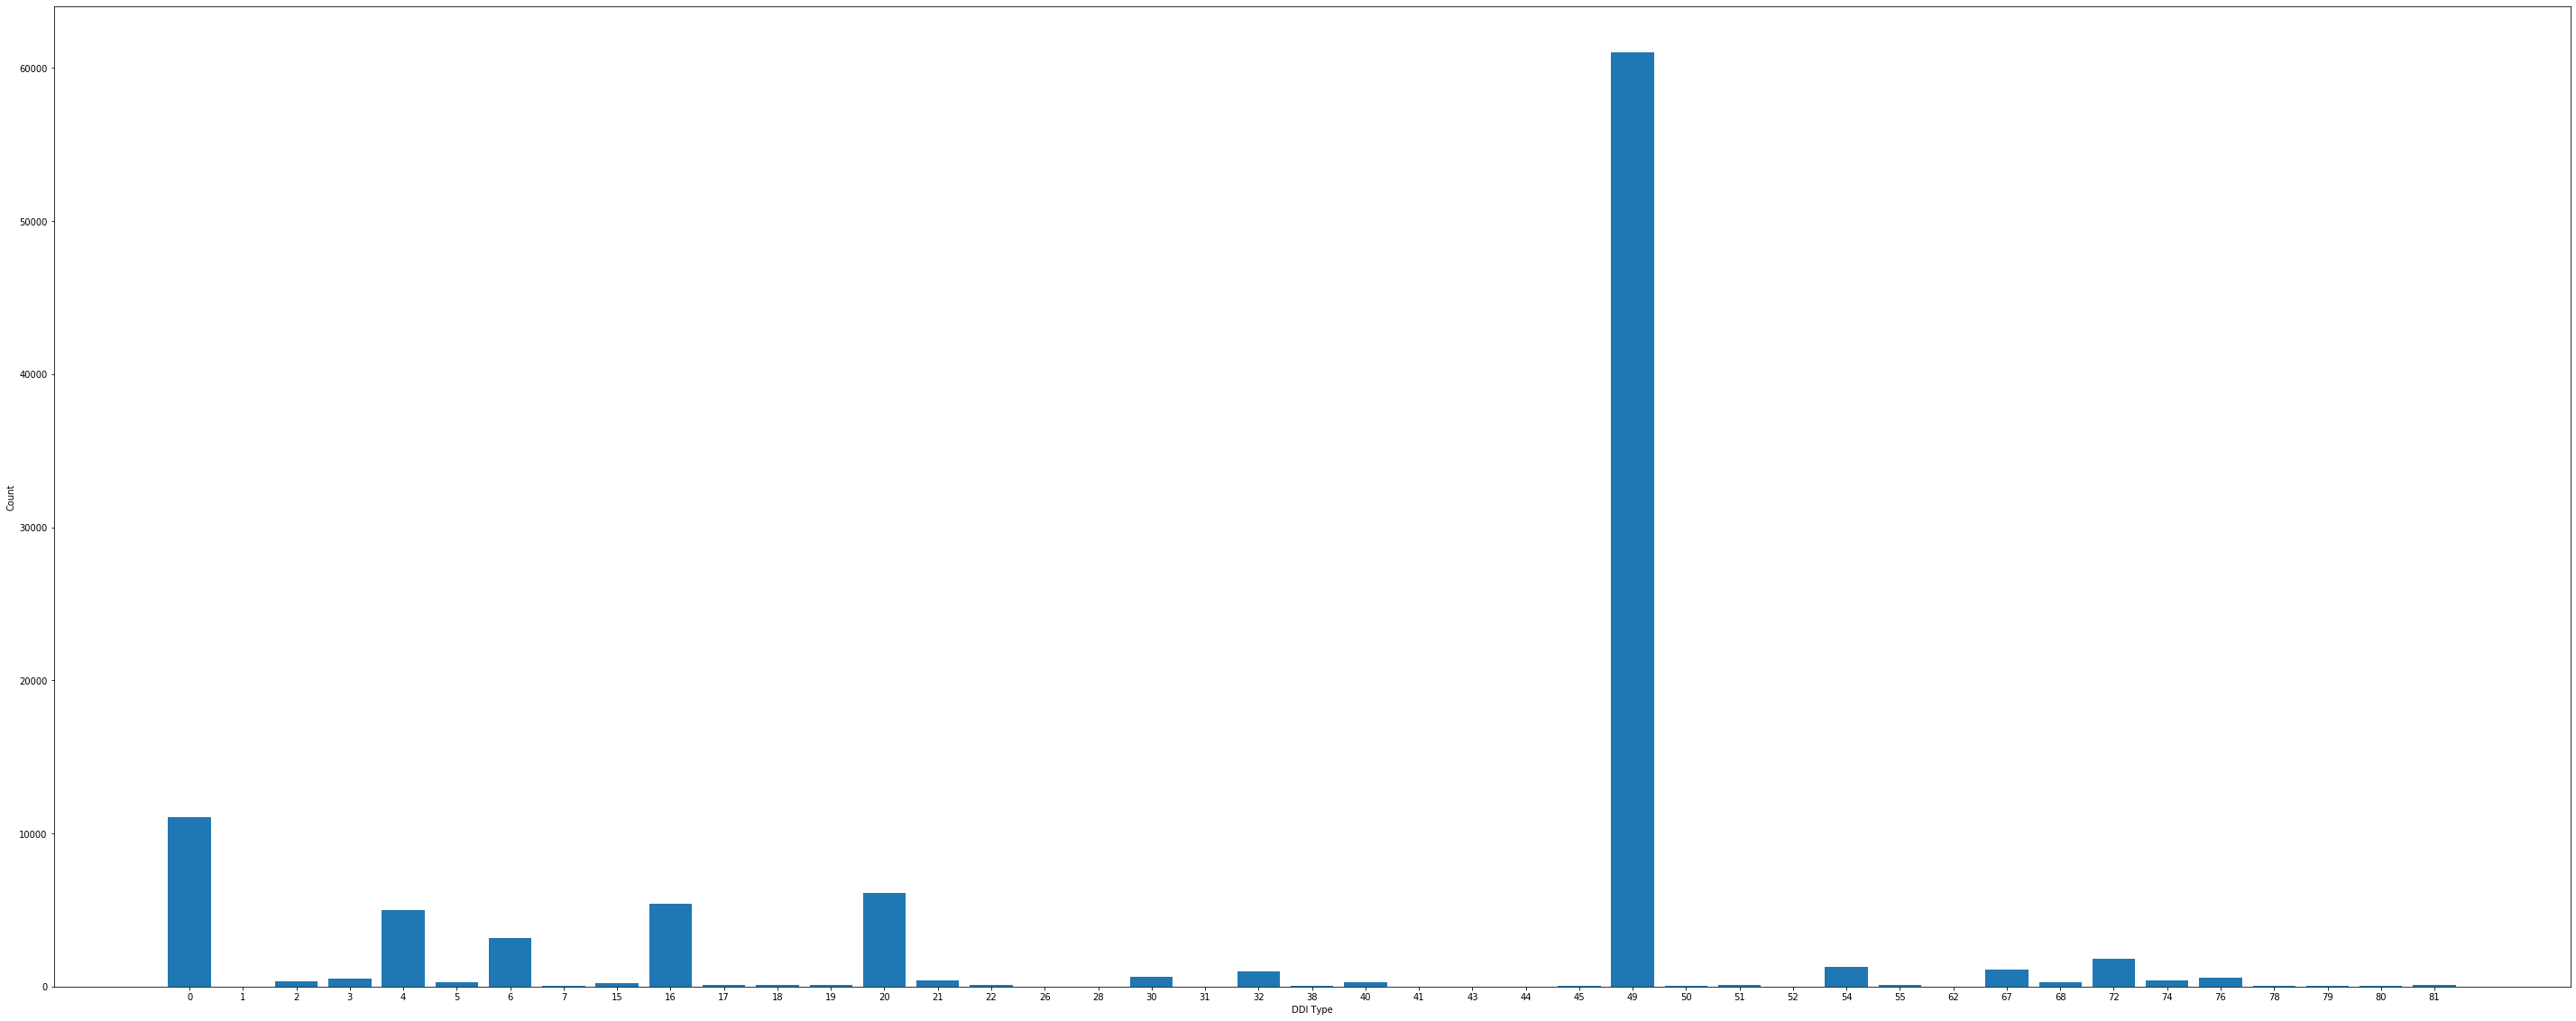

In [185]:
#plot count
plt.figure(figsize=(50,20))
desired_DDI_str = [str(x) for x in desired_DDI]
plt.bar( desired_DDI_str,list(count.values()))
plt.xlabel("DDI Type")
plt.ylabel("Count")b
plt.show()

NameError: name 'getwd' is not defined